# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [1]:
import numpy as np
from numpy.linalg import det, inv

In [2]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [3]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)
 
    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)
    
    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [148]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    # return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
    self.result = 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x
    # print(f"Predict log condicitional of {class_idx}: ", self.result)
    return self.result
  

In [5]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [6]:
# hiperparámetros
rng_seed = 6543

In [7]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [8]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [9]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [10]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [126]:
qda = QDA()

# La funcion fit se puede pasar un tercer parámetro que actuaria como 
qda.fit(train_x, train_y)

In [127]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [128]:
%%timeit

qda.predict(test_x)

4.41 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

5.73 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.>
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

1.1 Distribución apriori uniforme

In [13]:
# Preparamos los dataset de evaluación y prueba
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)


In [17]:
# Entrenamos el modelo
# La funcion fit se puede pasar un tercer parámetro para modificar la distribucion a priori. En el caso de la distribución uniforme no hace falta pasarle el marametro, toda vez que
# que lo calcula directamente del data set.
qda_uniforme = QDA()
qda_uniforme.fit(train_x, train_y)#, np.array([0.33, 0.33,0.33]))

print(f"Distribución a prioriri {np.exp(qda_uniforme.log_a_priori)}")


Distribución a prioriri [0.3        0.32222222 0.37777778]


In [18]:
train_acc = accuracy(train_y, qda_uniforme.predict(train_x))
test_acc = accuracy(test_y, qda_uniforme.predict(test_x))
y_full_predict = qda_uniforme.predict(X_full.T)


full_acc = accuracy(y_full.reshape(1,-1), qda_uniforme.predict(X_full.T))

print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f} and full error is {1-full_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167 and full error is 0.0133


2.2 Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)

In [135]:
# Entrenamos el modelo
# Vamos a entrenar tres modelos cada uno de ellos tendrá el nombre de la especie más dominante en la distribución

a_priori_setosa = np.array([0.90, 0.05,0.05])
qda_setosa = QDA()
qda_setosa.fit(train_x, train_y, a_priori_setosa)
print(f"Distribución a prioriri setosa {qda_setosa.log_a_priori}")

a_priori_versicolor = np.array([0.05, 0.9,0.05])
qda_versicolor = QDA()
qda_versicolor.fit(train_x, train_y, a_priori_versicolor)
print(f"Distribución a prioriri versicolor {qda_versicolor.log_a_priori}")

a_priori_virginica = np.array([0.05, 0.05, 0.9])
qda_virginica = QDA()
qda_virginica.fit(train_x, train_y, a_priori_virginica)
print(f"Distribución a prioriri virginica {qda_virginica.log_a_priori}")

print(f"Distribución a prioriri iniforme {qda_uniforme.log_a_priori}")

Distribución a prioriri setosa [-0.10536052 -2.99573227 -2.99573227]
Distribución a prioriri versicolor [-2.99573227 -0.10536052 -2.99573227]
Distribución a prioriri virginica [-2.99573227 -2.99573227 -0.10536052]
Distribución a prioriri iniforme [-1.2039728  -1.13251384 -0.97344915]


In [136]:
# Previmanete saquemos la cantidad de ocurrencias de cada especie en los dataset de entrenamiento y prueba
distribution_train = np.bincount(qda_uniforme.encoder.transform(train_y).flatten().astype(int)) / train_y.size
distribution_test = np.bincount(qda_uniforme.encoder.transform(test_y).flatten().astype(int)) / test_y.size
print(f"Ocurrencias de cada especie en el set de entrenamientos {distribution_train}")
print(f"Ocurrencias de cada especie en el set de test {distribution_test}")
print("\n")

# Full dataset

setosa_train_acc = accuracy(train_y, qda_setosa.predict(train_x))
setosa_test_acc = accuracy(test_y, qda_setosa.predict(test_x))
setosa_full_acc = accuracy(y_full.reshape(1,-1), qda_setosa.predict(X_full.T))
print(f"Setosa Train (apparent) error is {1-setosa_train_acc:.4f} while test error is {1-setosa_test_acc:.4f} and full error {1-setosa_full_acc:.4f}")

versicolor_train_acc = accuracy(train_y, qda_versicolor.predict(train_x))
versicolor_test_acc = accuracy(test_y, qda_versicolor.predict(test_x))
versicolor_full_acc = accuracy(y_full.reshape(1,-1), qda_versicolor.predict(X_full.T))
print(f"Versicolor Train (apparent) error is {1-versicolor_train_acc:.4f} while test error is {1-versicolor_test_acc:.4f} and full error {1-versicolor_full_acc:.4f}")

virginica_train_acc = accuracy(train_y, qda_virginica.predict(train_x))
virginica_test_acc = accuracy(test_y, qda_virginica.predict(test_x))
virginica_full_acc = accuracy(y_full.reshape(1,-1), qda_virginica.predict(X_full.T))
print(f"Virginica Train (apparent) error is {1-virginica_train_acc:.4f} while test error is {1-virginica_test_acc:.4f} and full error {1-virginica_full_acc:.4f}")

Ocurrencias de cada especie en el set de entrenamientos [0.3        0.32222222 0.37777778]
Ocurrencias de cada especie en el set de test [0.38333333 0.35       0.26666667]


Predict log condicitional of 0:  [[6.4184618]]
Predict log condicitional of 1:  [[-50.11759846]]
Predict log condicitional of 2:  [[-110.86673964]]
Predict log condicitional of 0:  [[-334.77620182]]
Predict log condicitional of 1:  [[-7.48505676]]
Predict log condicitional of 2:  [[0.82569464]]
Predict log condicitional of 0:  [[6.7266636]]
Predict log condicitional of 1:  [[-42.2913326]]
Predict log condicitional of 2:  [[-99.14226157]]
Predict log condicitional of 0:  [[-429.58996554]]
Predict log condicitional of 1:  [[3.10837427]]
Predict log condicitional of 2:  [[1.49391586]]
Predict log condicitional of 0:  [[-246.1439516]]
Predict log condicitional of 1:  [[5.28804001]]
Predict log condicitional of 2:  [[-2.38410699]]
Predict log condicitional of 0:  [[-465.06706329]]
Predict log condicitional of 1:  [[-5.8

De los resultados obtenidos, no se observan diferencias significativas al entrenar el modelo con las diferentes distribuciones (uniforme y las 3 distribuciones desbalancedas). A nuestro entender, esto se debe a que existe una clara separación entre clases, es decir que las caracteristicas de las tres especies de plantas difieren marcadamente entre si. Esta situación genera que la influencia que genera $\pi_j sea mínima. A continuación se realiza un gráfico de dispersión para observar la separación de clases. 

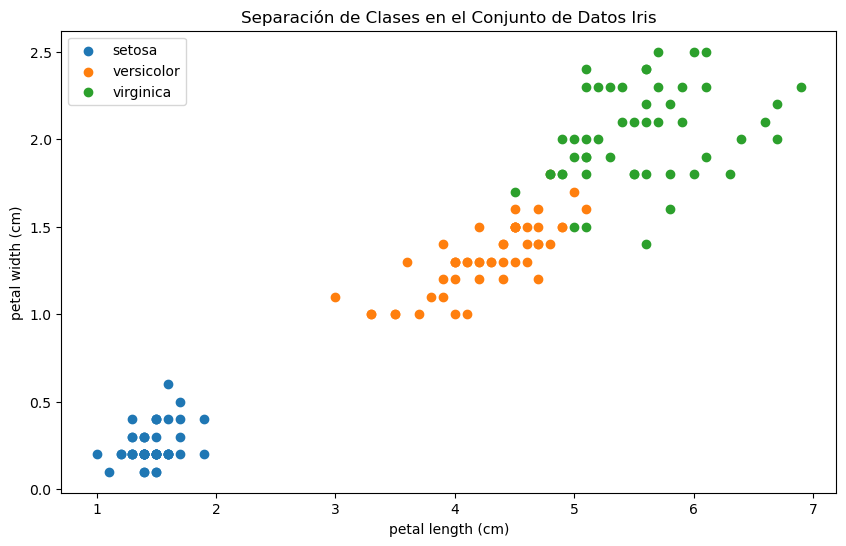

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Mapear los valores numéricos a nombres de clases
df['target'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Visualización de la separación entre clases usando las dos características más separables
plt.figure(figsize=(10, 6))
for class_name in data.target_names:
    subset = df[df['target'] == class_name]
    plt.scatter(subset[data.feature_names[2]], subset[data.feature_names[3]], label=class_name)
plt.xlabel(data.feature_names[2])
plt.ylabel(data.feature_names[3])
plt.legend()
plt.title('Separación de Clases en el Conjunto de Datos Iris')
plt.show()

2.Repetir el punto anterior para el dataset *penguin*.

In [140]:
# Preparamos los dataset de evaluación y prueba
X_penguins_full, y_penguins_full = get_penguins()
train_penguins_x, train_penguins_y, test_penguins_x, test_penguins_y = split_transpose(X_penguins_full, y_penguins_full, 0.4, rng_seed)

In [146]:
# Entrenamos el modelo
# La funcion fit se puede pasar un tercer parámetro para modificar la distribucion a priori. En el caso de la distribución uniforme no hace falta pasar el parámetro, toda vez que
# que lo calcula directamente del data set.
qda_penguin = QDA()
qda_penguin.fit(train_penguins_x, train_penguins_y)#, np.array([0.33, 0.33,0.33]))

print(f"Distribución a prioriri {np.exp(qda_penguin.log_a_priori)}")

Distribución a prioriri [0.4097561 0.1902439 0.4      ]


In [142]:
train_penguins_acc = accuracy(train_penguins_y, qda_penguin.predict(train_penguins_x))
test_penguins_acc = accuracy(test_penguins_y, qda_penguin.predict(test_penguins_x))

full_penguins_acc = accuracy(y_penguins_full.reshape(1,-1), qda_penguin.predict(X_penguins_full.T))

print(f"Train (apparent) error is {1-train_penguins_acc:.4f} while test error is {1-test_penguins_acc:.4f} and full error is {1-full_penguins_acc:.4f}")

Predict log condicitional of 0:  [[-39.56320098]]
Predict log condicitional of 1:  [[-46.67323436]]
Predict log condicitional of 2:  [[-10.23423757]]
Predict log condicitional of 0:  [[-11.43181317]]
Predict log condicitional of 1:  [[-25.69838188]]
Predict log condicitional of 2:  [[-84.80343581]]
Predict log condicitional of 0:  [[-13.69956617]]
Predict log condicitional of 1:  [[-27.88351973]]
Predict log condicitional of 2:  [[-116.08488424]]
Predict log condicitional of 0:  [[-37.22569519]]
Predict log condicitional of 1:  [[-42.02955646]]
Predict log condicitional of 2:  [[-11.88534854]]
Predict log condicitional of 0:  [[-39.92169323]]
Predict log condicitional of 1:  [[-45.24049351]]
Predict log condicitional of 2:  [[-8.89835226]]
Predict log condicitional of 0:  [[-12.28981036]]
Predict log condicitional of 1:  [[-10.84815638]]
Predict log condicitional of 2:  [[-52.3607401]]
Predict log condicitional of 0:  [[-9.70668686]]
Predict log condicitional of 1:  [[-16.35437347]]
Pr

In [151]:
qda_penguin_uniforme = QDA()
qda_penguin_uniforme.fit(train_penguins_x, train_penguins_y, np.array([0.33, 0.33,0.33]))

print(f"Distribución a prioriri {qda_penguin_uniforme.log_a_priori}")

Distribución a prioriri [-1.10866262 -1.10866262 -1.10866262]


In [150]:
# train_penguins_uniform_acc = accuracy(train_penguins_y, qda_penguin_uniforme.predict(train_penguins_x))
# test_penguins_uniform_acc = accuracy(test_penguins_y, qda_penguin_uniforme.predict(test_penguins_x))
full_penguins_uniform_acc = accuracy(y_penguins_full.reshape(1,-1), qda_penguin_uniforme.predict(X_penguins_full.T))

# print(f"Train (apparent) error is {1-train_penguins_uniform_acc:.4f} while test error is {1-test_penguins_uniform_acc:.4f} and full error is {1-full_penguins_uniform_acc:.4f}")

Predict log condicitional of 0:  [[-10.02419236]]
Predict log condicitional of 1:  [[-22.28371228]]
Predict log condicitional of 2:  [[-89.01952194]]
Predict log condicitional of 0:  [[-9.54639271]]
Predict log condicitional of 1:  [[-15.9220073]]
Predict log condicitional of 2:  [[-58.53606773]]
Predict log condicitional of 0:  [[-11.06121957]]
Predict log condicitional of 1:  [[-16.80700829]]
Predict log condicitional of 2:  [[-66.15578265]]
Predict log condicitional of 0:  [[-10.47770035]]
Predict log condicitional of 1:  [[-30.15713511]]
Predict log condicitional of 2:  [[-93.11734287]]
Predict log condicitional of 0:  [[-11.9540392]]
Predict log condicitional of 1:  [[-31.10144224]]
Predict log condicitional of 2:  [[-114.97327332]]
Predict log condicitional of 0:  [[-9.82030177]]
Predict log condicitional of 1:  [[-18.50719889]]
Predict log condicitional of 2:  [[-75.29050657]]
Predict log condicitional of 0:  [[-11.43362126]]
Predict log condicitional of 1:  [[-28.65170688]]
Pre

In [138]:
# Entrenamos el modelo
# Vamos a entrenar tres modelos cada uno de ellos tendrá el nombre de la especie más dominante en la distribución

a_priori_adelie = np.array([0.9, 0.05,0.05])
qda_adelie = QDA()
qda_adelie.fit(train_penguins_x, train_penguins_y, a_priori_adelie)
print(f"Distribución a priori adelie {qda_adelie.log_a_priori}")

a_priori_chinstrap = np.array([0.05, 0.9,0.05])
qda_chinstrap = QDA()
qda_chinstrap.fit(train_penguins_x, train_penguins_y, a_priori_chinstrap)
print(f"Distribución a priori chinstrap {qda_chinstrap.log_a_priori}")

a_priori_gentoo = np.array([0.05, 0.05, 0.9])
qda_gentoo = QDA()
qda_gentoo.fit(train_penguins_x, train_penguins_y, a_priori_gentoo)
print(f"Distribución a priori gentoo {qda_gentoo.log_a_priori}")


Distribución a priori adelie [-0.10536052 -2.99573227 -2.99573227]
Distribución a priori chinstrap [-2.99573227 -0.10536052 -2.99573227]
Distribución a priori gentoo [-2.99573227 -2.99573227 -0.10536052]


In [139]:
# Previmanete saquemos la cantidad de ocurrencias de cada especie en los dataset de entrenamiento y prueba
distribution_penguins_train = np.bincount(qda_penguin_uniforme.encoder.transform(train_penguins_y).flatten().astype(int)) / train_penguins_y.size
distribution_penguins_test = np.bincount(qda_penguin_uniforme.encoder.transform(test_penguins_y).flatten().astype(int)) / test_penguins_y.size
distribution_penguins_full = np.bincount(qda_penguin_uniforme.encoder.transform(y_penguins_full.reshape(1,-1)).flatten().astype(int)) / y_penguins_full.reshape(1,-1).size
print(f"Ocurrencias de cada especie en el set de entrenamientos {distribution_penguins_train}")
print(f"Ocurrencias de cada especie en el set de test {distribution_penguins_test}")
print(f"Ocurrencias de cada especie en el set full {distribution_penguins_full}")
print("\n")

# Full dataset

adelie_train_acc = accuracy(train_penguins_y, qda_adelie.predict(train_penguins_x))
adelie_test_acc = accuracy(test_penguins_y, qda_adelie.predict(test_penguins_x))
adelie_full_acc = accuracy(y_penguins_full.reshape(1,-1), qda_adelie.predict(X_penguins_full.T))
print(f"Adelie Train (apparent) error is {1-adelie_train_acc:.4f} while test error is {1-adelie_test_acc:.4f} and full error {1-adelie_full_acc:.4f}")

chinstrap_train_acc = accuracy(train_penguins_y, qda_chinstrap.predict(train_penguins_x))
chinstrap_test_acc = accuracy(test_penguins_y, qda_chinstrap.predict(test_penguins_x))
chinstrap_full_acc = accuracy(y_penguins_full.reshape(1,-1), qda_chinstrap.predict(X_penguins_full.T))
print(f"Chinstrap Train (apparent) error is {1-chinstrap_train_acc:.4f} while test error is {1-chinstrap_test_acc:.4f} and full error {1-chinstrap_full_acc:.4f}")

gentoo_train_acc = accuracy(train_penguins_y, qda_gentoo.predict(train_penguins_x))
gentoo_test_acc = accuracy(test_penguins_y, qda_gentoo.predict(test_penguins_x))
gentoo_full_acc = accuracy(y_penguins_full.reshape(1,-1), qda_gentoo.predict(X_penguins_full.T))
print(f"Gentoo Train (apparent) error is {1-gentoo_train_acc:.4f} while test error is {1-gentoo_test_acc:.4f} and full error {1-gentoo_full_acc:.4f}")

Ocurrencias de cada especie en el set de entrenamientos [0.4097561 0.1902439 0.4      ]
Ocurrencias de cada especie en el set de test [0.48905109 0.21167883 0.29927007]
Ocurrencias de cada especie en el set full [0.44152047 0.19883041 0.35964912]


Predict log condicitional of 0:  [[-39.56320098]]
Predict log condicitional of 1:  [[-46.67323436]]
Predict log condicitional of 2:  [[-10.23423757]]
Predict log condicitional of 0:  [[-11.43181317]]
Predict log condicitional of 1:  [[-25.69838188]]
Predict log condicitional of 2:  [[-84.80343581]]
Predict log condicitional of 0:  [[-13.69956617]]
Predict log condicitional of 1:  [[-27.88351973]]
Predict log condicitional of 2:  [[-116.08488424]]
Predict log condicitional of 0:  [[-37.22569519]]
Predict log condicitional of 1:  [[-42.02955646]]
Predict log condicitional of 2:  [[-11.88534854]]
Predict log condicitional of 0:  [[-39.92169323]]
Predict log condicitional of 1:  [[-45.24049351]]
Predict log condicitional of 2:  [[-8.89835226]]
P

In [129]:
import pandas as pd
import matplotlib.pyplot as plt


df_penguins, target_penguins = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')
df_penguins.drop(columns=['island', 'sex'], inplace=True)
mask = df_penguins.isna().sum(axis=1) == 0#.sum(axis=1) == 0
df_penguins = df_penguins[mask]
mapping_dic = {'Adelie':0, 'Chinstrap': 1, 'Gentoo':2}
reverse_mapping = ['Adelie', 'Chinstrap', 'Gentoo']
target_penguins = np.array(target_penguins[mask].map(mapping_dic))
proba = np.bincount(target_penguins).astype(int)/len(target_penguins)

print(proba)
fer= np.bincount(target_penguins)
# df_penguins = pd.DataFrame(data_penguins.data, columns=data_penguins.feature_names)
df_penguins['target'] = np.array(target_penguins)



[0.44152047 0.19883041 0.35964912]


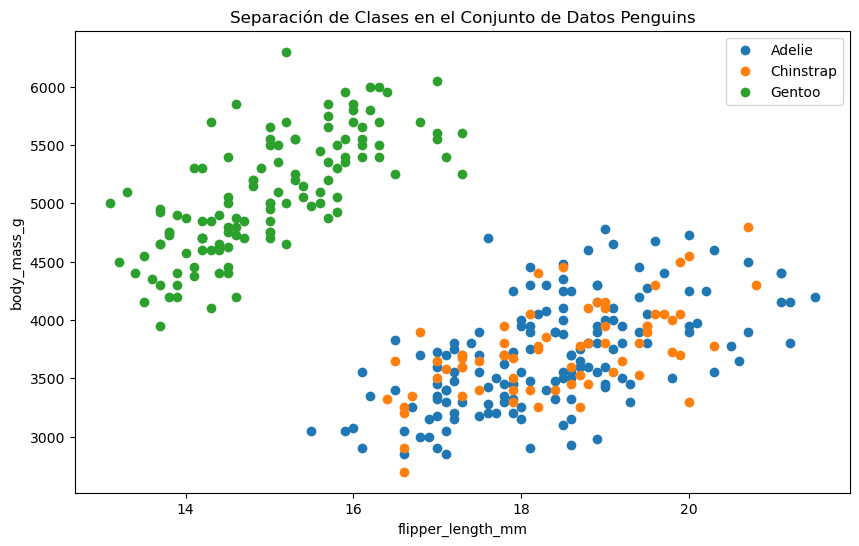

In [133]:


# Mapear los valores numéricos a nombres de clases
columns_names = list(df_penguins.columns)

# Visualización de la separación entre clases usando las dos características más separables
plt.figure(figsize=(10, 6))
for class_name in mapping_dic.values():
    subset = df_penguins[df_penguins['target'] == class_name]
    plt.scatter(subset[columns_names[1]], subset[columns_names[3]], label=reverse_mapping[class_name])
plt.xlabel(columns_names[2])
plt.ylabel(columns_names[3])
plt.legend()
plt.title('Separación de Clases en el Conjunto de Datos Penguins')
plt.show()

 ## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.